# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import numpy as np
import pandas as pd

import time

from matplotlib import pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 100)

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Sparkify_Churn_Analysis") \
    .config("spark.network.timeout","3601") \
    .config("spark.executor.heartbeatInterval","3600") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('medium-sparkify-event-data.json')
df.createOrReplaceTempView("log_table")
df.persist()
spark.sql('SELECT * FROM log_table LIMIT 10').toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


#### This dataset contains personal information such as first and last name. We don't need that for our analysis, so let's drop these columns.

In [4]:
df = df.drop('firstName', 'lastName')
df.createOrReplaceTempView("log_table")
spark.sql('SELECT * FROM log_table LIMIT 10').toPandas().head()

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,M,20,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,M,74,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,M,184,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,M,185,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,F,22,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


### Let's first drop duplicates and log entries from unregistered users.

In [5]:
df = df.dropDuplicates()
df = spark.sql(" SELECT * FROM log_table WHERE userID != '' ")
df.createOrReplaceTempView("log_table")

### Adding columns for hour, date, weekday and calendar week:

In [6]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_date = udf(lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).date()))
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday())
get_week = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).date().isocalendar()[1])
df = df.withColumn("date", get_date(df.ts))
df = df.withColumn("hour", get_hour(df.ts))
df = df.withColumn("weekday", get_weekday(df.ts))
df = df.withColumn("week", get_week(df.ts))
df.createOrReplaceTempView("log_table")

### Let's find out in which timeframe the data was collected.

In [7]:
ts_begin = spark.sql('SELECT MIN(ts) FROM log_table').first()[0]
ts_end = spark.sql('SELECT MAX(ts) FROM log_table').first()[0]
begin_datettime = datetime.datetime.fromtimestamp(ts_begin/1000)
end_datetime = datetime.datetime.fromtimestamp(ts_end/1000)
print('Data was collected between {} and {} over {} days.'.format(str(begin_datettime), str(end_datetime), (ts_end - ts_begin)//(24*3600000)))

Data was collected between 2018-10-01 02:00:11 and 2018-12-01 01:01:06 over 61 days.


### The suggestion was to define churn as following events:
1. Customer cancelled account.
2. Customer downgraded account.

The first case is easier to track. Since the number of cancelled auth and visits to "Cancellation Confirmation" page is same, we can assume, that after visiting the page and getting the cancelled auth the users have cancelled their accounts.

The second case is more complicated and ambiguous, because the user behaviour of someone who downgraded their account may not be different from that of a paying user.They may choose to downgrade because they don't use the service frequently or just don't have the financial ability to pay for higher level service. Also let's keep in mind that we still generate revenue from free level users by rolling ads.

### In this notebook we define churn as account cancellation.

In [8]:
get_churn_cancel = udf(lambda x: int(x=='Cancellation Confirmation'), IntegerType())
df = df.withColumn('churn_cancelled', get_churn_cancel('page'))
df.createOrReplaceTempView("log_table")

### Outliers

#### Early churn
If a user cancelled account in a timeframe less than a five days from beginning of observations we are dealing with early churn. In this case this user's data will not be compareable to others.

In [9]:
# let's find early churn users:
early_churn = spark.sql(''' SELECT userID, ts FROM log_table WHERE churn_cancelled = 1 ''').toPandas()
early_churn.sort_values('ts', inplace = True)
early_churn[early_churn['ts'] < ts_begin + 3600*24*5*1000]
early_churn = early_churn[early_churn['ts'] < ts_begin + 3600*24*5*1000]
list_remove = early_churn.userID.tolist()

#### Non-use
Some customers have very low interaction level. It is possible that they do not use the service at all. Keeping them in the analysis will skew the distribution of our features. We will assume that users with less than one interaction per day on average are effectively not using our service.

In [10]:
usage_statistic = spark.sql(''' SELECT userID, count(ts) AS interactions, MAX(churn_cancelled) AS churn FROM log_table GROUP BY userID ''').toPandas()

No handles with labels found to put in legend.


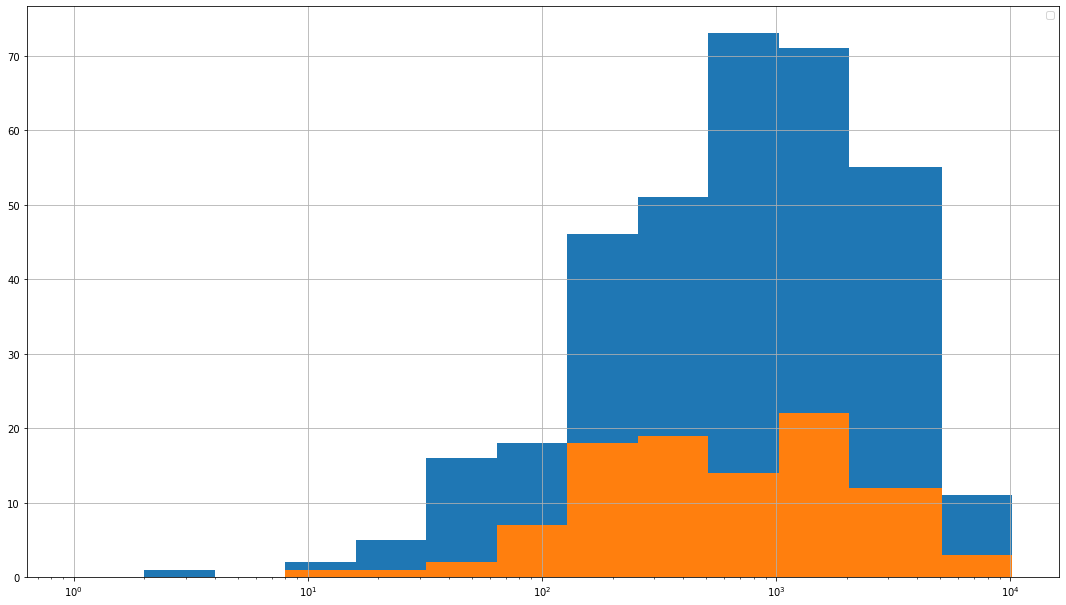

In [11]:
usage_statistic.groupby('churn')['interactions'].hist(bins = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 5096, 10192])
plt.xscale('log')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [12]:
non_users = usage_statistic[usage_statistic['interactions']<60].userID.tolist()
list_remove.extend([x for x in non_users if not x in list_remove])

In [13]:
print('We will have to remove {} users from our analysis due to early churn or low number of interactions.'.format(len(list_remove)))
print('User IDs: ', ' '.join(list_remove))

We will have to remove 36 users from our analysis due to early churn or low number of interactions.
User IDs:  208 231 100001 100013 236 100030 156 100032 100044 100036 271 200016 64 3 133 8 267 200035 177 200048 297 176 115 200033 300037 200031 300003 266 300026 200044 63 200012 123 300043 137 200049


In [14]:
df = spark.sql('SELECT * FROM log_table WHERE NOT(userID IN ({}))'.format(','.join(list_remove)))
df.createOrReplaceTempView("log_table")

### Adding a column for skipped songs count

In [15]:
df_songs = spark.sql('SELECT *, (LEAD(ts) OVER(ORDER BY userId, sessionID, ts) - ts)/1000 - length AS skipped FROM log_table WHERE page = "NextSong" ORDER BY userId, sessionID, ts')
df_songs.createOrReplaceTempView("song_table")
df_songs.persist()

DataFrame[artist: string, auth: string, gender: string, itemInSession: bigint, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, date: string, hour: string, weekday: string, week: string, churn_cancelled: int, skipped: double]

In [16]:
df_skipped = spark.sql('SELECT userId,\
                        COUNT(CASE WHEN skipped>30 AND level = "free" THEN 1 END) AS skipped_songs_free,\
                        COUNT(CASE WHEN skipped>30 AND level = "paid" THEN 1 END) AS skipped_songs_paid \
                        FROM song_table GROUP BY userId').toPandas()

# Feature Engineering

##### Methodology

In this analysis we will focus on user specific factors such as:
 * number of songs played
 * number of songs skipped
 * number of different songs played
 * number of different artists
 * number of sessions
 * number of upgrades
 * number of downgrades
 * page visits
     * downgrade
     * upgrade
     * thumbs down
     * thumbs up
     * roll advert
     * home
     * logout
     * settings
     * save settings
     * add to playlist
     * help
     * error
     * about
     * add friend

In [17]:
df_churn = spark.sql('''
SELECT userId,\
COUNT(CASE WHEN page = "NextSong" AND level = "free" THEN 1 END) AS song_count_free, \
COUNT(CASE WHEN page = "NextSong" AND level = "paid" THEN 1 END) AS song_count_paid, \
COUNT(DISTINCT song) AS dist_song_count, \
COUNT(DISTINCT artist) AS dist_artist_count, \
COUNT(DISTINCT (CASE WHEN level = "free" THEN sessionId END)) AS session_count_free, \
COUNT(DISTINCT (CASE WHEN level = "paid" THEN sessionId END)) AS session_count_paid, \
COUNT(DISTINCT sessionId) AS session_count, \
MAX(itemInSession) AS max_items_in_session, \
COUNT(CASE WHEN status = 307 AND level = "free" THEN 1 END) AS status_307_count_free, \
COUNT(CASE WHEN status = 307 AND level = "paid" THEN 1 END) AS status_307_count_paid, \
COUNT(CASE WHEN page = "Submit Downgrade" THEN 1 END) AS downgrade_count, \
COUNT(CASE WHEN page = "Submit Upgrade" THEN 1 END) AS upgrade_count, \
COUNT(CASE WHEN page = "Cancellation Confirmation" THEN 1 END) AS churn, \
COUNT(CASE WHEN page = "Home" THEN 1 END) AS page_visits_home, \
COUNT(CASE WHEN page = "Logout" THEN 1 END) AS page_visits_logout, \
COUNT(CASE WHEN page = "Settings" THEN 1 END) AS page_visits_settings, \
COUNT(CASE WHEN page = "Save Settings" THEN 1 END) AS page_visits_save_settings, \
COUNT(CASE WHEN page = "Thumbs Down" THEN 1 END) AS page_visits_thumbs_down, \
COUNT(CASE WHEN page = "Thumbs Up" THEN 1 END) AS page_visits_thumbs_up, \
COUNT(CASE WHEN page = "Upgrade" THEN 1 END) AS page_visits_upgrade, \
COUNT(CASE WHEN page = "Downgrade" THEN 1 END) AS page_visits_downgrade, \
COUNT(CASE WHEN page = "Roll Advert" AND level = "free" THEN 1 END) AS page_visits_roll_advert_free, \
COUNT(CASE WHEN page = "Roll Advert" AND level = "paid" THEN 1 END) AS page_visits_roll_advert_paid, \
COUNT(CASE WHEN page = "About" THEN 1 END) AS page_visits_about, \
COUNT(CASE WHEN page = "Add to Playlist" THEN 1 END) AS page_visits_add_to_playlist, \
COUNT(CASE WHEN page = "Add Friend" THEN 1 END) AS page_visits_add_friend, \
COUNT(CASE WHEN page = "Help" THEN 1 END) AS page_visits_help, \
COUNT(CASE WHEN page = "Error" AND level = "free" THEN 1 END) AS page_visits_error_free, \
COUNT(CASE WHEN page = "Error" AND level = "paid" THEN 1 END) AS page_visits_error_paid \
FROM log_table GROUP BY userID''').toPandas()
df_churn['song_variety'] = df_churn['dist_song_count'] / (df_churn['song_count_free'] + df_churn['song_count_paid'])
df_churn['artist_variety'] = df_churn['dist_artist_count'] / df_churn['dist_song_count']

In [18]:
df_merge = pd.merge(left = df_churn, right = df_skipped, on ='userId')

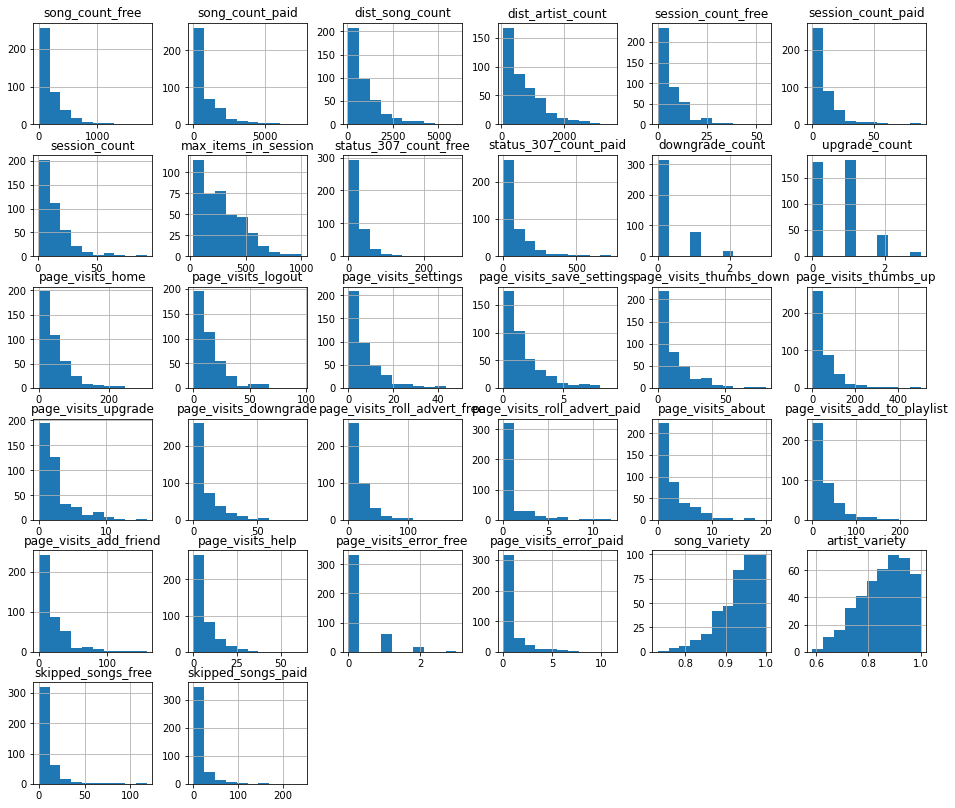

In [19]:
df_merge.drop(columns = ['churn']).hist(figsize = (16,14));

Let's rescale the statistics with the number of sessions.

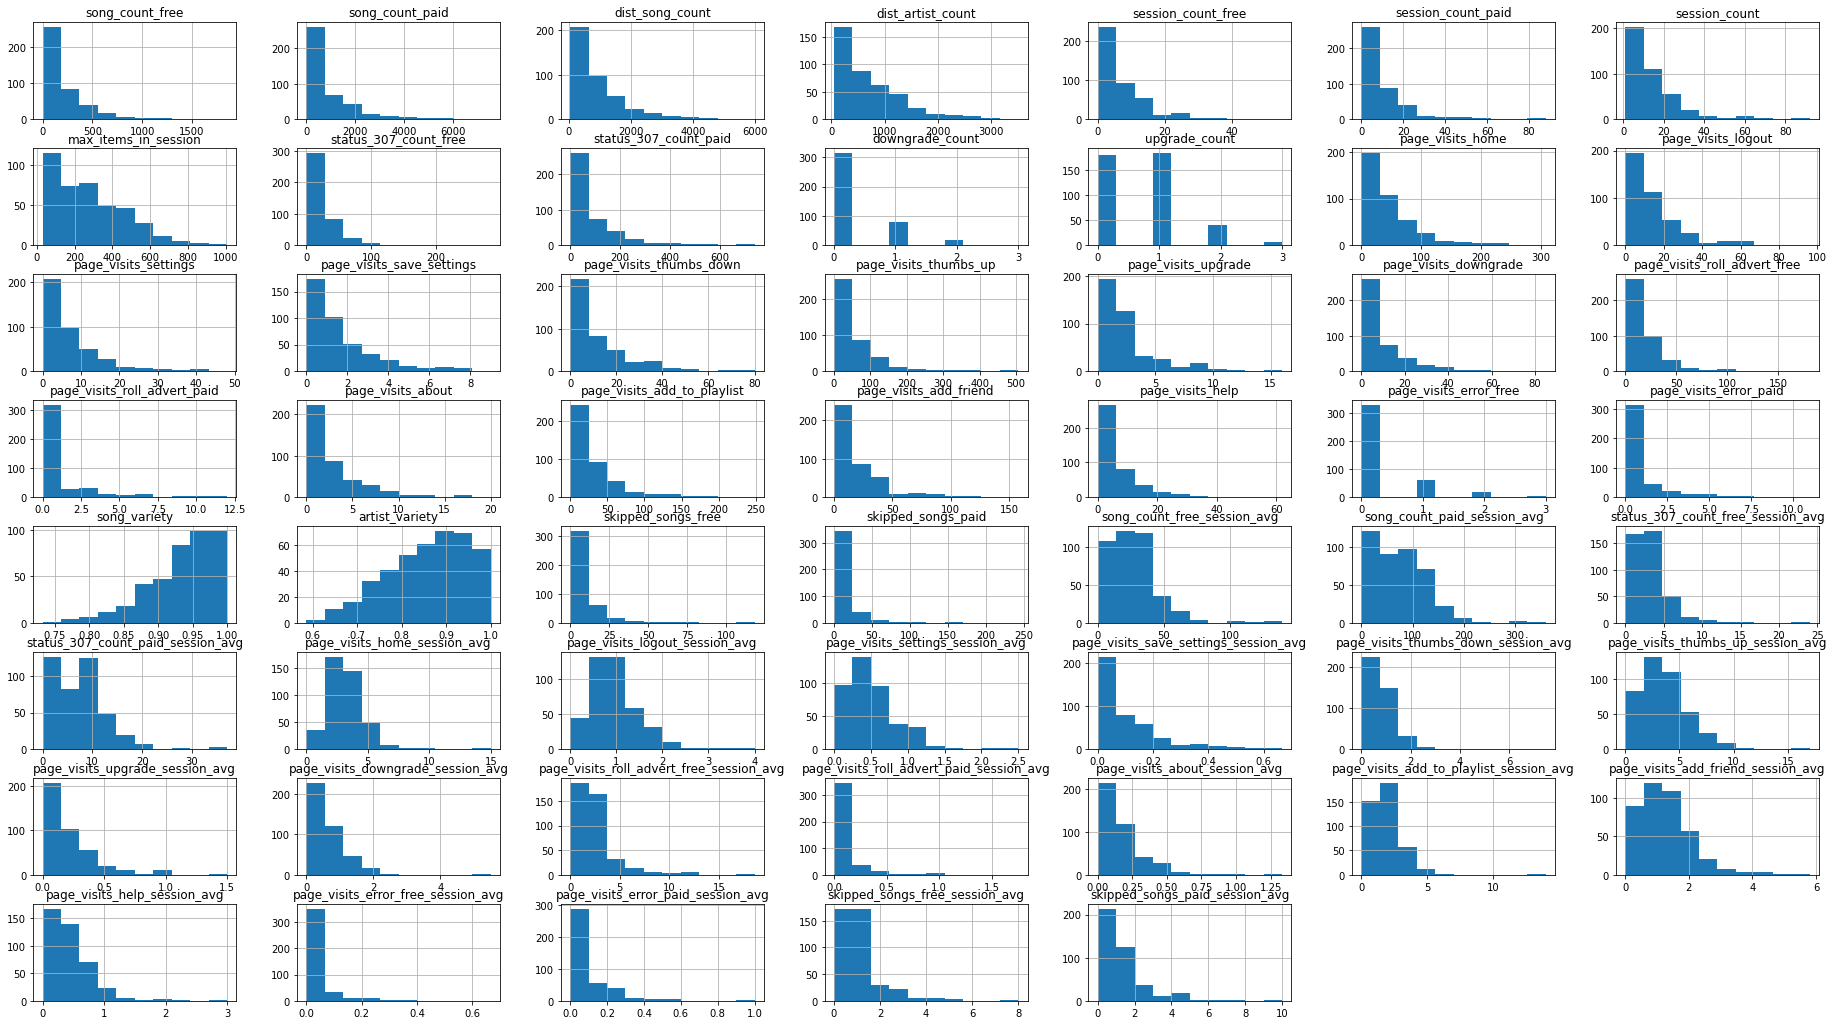

In [20]:
df_div = df_merge.copy(deep = True)
static_columns = ['dist_song_count', 'dist_artist_count', 'song_variety', 'artist_variety', 'userId', 'session_count_free',
                  'session_count_paid', 'session_count', 'downgrade_count', 'upgrade_count', 'max_items_in_session', 'churn']
for col in df_div.columns:
    if not(col in static_columns):
        if("free" in col):
            df_div[col+'_session_avg'] = df_div[col].div(df_churn.session_count_free)
        elif("paid" in col):
            df_div[col+'_session_avg'] = df_div[col].div(df_churn.session_count_paid)
        else:
            df_div[col+'_session_avg'] = df_div[col].div(df_churn.session_count)
df_div.fillna(0, inplace = True)
df_div.drop(columns = ['churn']).hist(figsize = (32,18));

# Machine Learning
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## 1. Supervised learning
Supervised learning algorithms train classifiers based on known input - output pairs. To evaluate the results the data must be split into training and testing data. To comapre different models we will use validation data.

### 1.1 Separating data into training, testing and validation datasets.
#### The number of users is low and the number of those who churned even lower.
#### The algorithm repeats the splitting as long as we don't have at least 20% of churned users in both test and validate datasets.

In [21]:
train, validate, test = np.split(df_div.sample(frac=1), [int(.6*len(df_div)), int(.8*len(df_div))])
while (len(validate[validate['churn']==1]) < len(df_div[df_div['churn']==1]) // 5) or \
        (len(test[test['churn']==1]) < len(df_div[df_div['churn']==1]) // 5) or \
        (len(test[test['churn']==1]) != len(validate[validate['churn']==1])):
        train, validate, test = np.split(df_div.sample(frac=1), [int(.6*len(df_div)), int(.8*len(df_div))])

In [22]:
X_val = validate.drop(columns = ['userId', 'churn'])
y_val = validate['churn']

X_test = test.drop(columns = ['userId', 'churn'])
y_test = test['churn']

X_train = train.drop(columns = ['userId', 'churn'])
y_train = train['churn']

We are dealing with imbalanced classes here. One way to account for that would be to downsample the majority class. This is  an easy way to balance data, but it also reduces the variability in the majority class and therefore the classifiers may be biased. For this reason we will upsample the minority class in the training data.

In [23]:
X_train = X_train.append(X_train[y_train == 1]).append(X_train[y_train == 1]).append(X_train[y_train == 1])
y_train = y_train.append(y_train[y_train == 1]).append(y_train[y_train == 1]).append(y_train[y_train == 1])

### 1.2 Creating ML pipeline

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [25]:
transformers = [
                QuantileTransformer(n_quantiles = 100, output_distribution = 'uniform'),
                QuantileTransformer(n_quantiles = 100, output_distribution = 'normal'),
                PowerTransformer()
               ]
classifiers =  [
                DecisionTreeClassifier(random_state=42), 
                RandomForestClassifier(random_state=42),
                AdaBoostClassifier(random_state=42),
                MLPClassifier(random_state=42, hidden_layer_sizes=(100,10), early_stopping = True),
                GaussianNB(),
                LinearSVC(random_state=42, class_weight='balanced'),
                LogisticRegression(random_state=42, class_weight='balanced', solver = 'saga')
               ]

### 1.3 Running grid search

In [26]:
def print_score(estimator, X_test, y_test, print_scores):
    y_pred = estimator.predict(X_test)
    if(print_scores):
        print('True positives: {}'.format(((y_pred == 1) & (y_test == 1)).sum()))
        print('False positives: {}'.format(((y_pred == 1) & (y_test == 0)).sum()))
        print('True negatives: {}'.format(((y_pred == 0) & (y_test == 0)).sum()))
        print('False negatives: {}'.format(((y_pred == 0) & (y_test == 1)).sum()))
        print('F1 score: {}\nPrecision: {}\nRecall: {}'.format(
            f1_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        ))
    return({
        'f1':f1_score(y_test, y_pred),
        'precision':precision_score(y_test, y_pred),
        'recall':recall_score(y_test, y_pred)
    })

In [27]:
def run_cv(transformers, classifiers, X_train, y_train, X_test, y_test, score_function, verbose):
    best_score = 0
    pipelines = {}
    for trans in transformers:
        for clf in classifiers:
            pipeline = Pipeline([('trans', trans), ('clf', clf)])
            pipeline.fit(X_train, y_train)
            if(verbose):
                print('\n')
                print(pipeline)
            scores = print_score(pipeline, X_test, y_test, verbose)   
            pipelines[scores[score_function]] = pipeline
    return(pipelines)

In [28]:
pipelines_dict = run_cv(transformers, classifiers, X_train, y_train, X_test, y_test, 'f1', False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "

In [29]:
best_est = pipelines_dict[sorted(pipelines_dict.keys())[-1]]
print(best_est)
print_score(best_est, X_test, y_test, True);

Pipeline(steps=[('trans',
                 QuantileTransformer(n_quantiles=100,
                                     output_distribution='normal')),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='saga'))])
True positives: 6
False positives: 19
True negatives: 47
False negatives: 11
F1 score: 0.28571428571428564
Precision: 0.24
Recall: 0.35294117647058826


### 1.4 Evaluating the 5 best pipelines on validation set

In [30]:
for i in range(1,6):
    pipe = pipelines_dict[sorted(pipelines_dict.keys())[-i]]
    print(pipe)
    print_score(pipe, X_val, y_val, True)
    print('\n')

Pipeline(steps=[('trans',
                 QuantileTransformer(n_quantiles=100,
                                     output_distribution='normal')),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='saga'))])
True positives: 7
False positives: 20
True negatives: 45
False negatives: 10
F1 score: 0.3181818181818182
Precision: 0.25925925925925924
Recall: 0.4117647058823529


Pipeline(steps=[('trans',
                 QuantileTransformer(n_quantiles=100,
                                     output_distribution='normal')),
                ('clf', LinearSVC(class_weight='balanced', random_state=42))])
True positives: 9
False positives: 22
True negatives: 43
False negatives: 8
F1 score: 0.375
Precision: 0.2903225806451613
Recall: 0.5294117647058824


Pipeline(steps=[('trans', PowerTransformer()),
                ('clf',
                 MLPClassifier(early_stopping=True,
                           

### 1.5 Tuning best estimators' hyperparameters.
Let's tune parameters of our algorithms.

In [31]:
def build_cv(pipeline, parameters):

    # create grid search object
    cv = GridSearchCV(pipeline, param_grid = parameters, verbose = 5, n_jobs = -1, scoring = 'f1', refit = True,
                     return_train_score = False)
    
    return cv

#### Logistic Regression

In [32]:
LR_pipe = Pipeline([
        ('trans', PowerTransformer()),
        ('clf', LogisticRegression(random_state=42))
    ])

LR_pipe_param = {
    'clf__tol': [0.001, 0.01, 0.1],
    'clf__max_iter': range(5000,15000,2000),
    'clf__solver': ['liblinear', 'saga'],
    'clf__class_weight': [None, 'balanced']
}

LR_cv = build_cv(LR_pipe, LR_pipe_param)

In [33]:
LR_cv.fit(X_train, y_train);
print(LR_cv.best_estimator_)
print_score(LR_cv.best_estimator_, X_val, y_val, True);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.3s finished


Pipeline(steps=[('trans', PowerTransformer()),
                ('clf',
                 LogisticRegression(max_iter=5000, random_state=42,
                                    solver='liblinear', tol=0.001))])
True positives: 9
False positives: 14
True negatives: 51
False negatives: 8
F1 score: 0.45
Precision: 0.391304347826087
Recall: 0.5294117647058824


#### Random Forest

In [34]:
RF_pipe = Pipeline([
        ('trans', PowerTransformer()),
        ('clf', RandomForestClassifier(random_state=42))
    ])

RF_pipe_param = {
    'clf__n_estimators': range(20,220,50),
    'clf__max_depth': range(5,25,5),
    'clf__min_samples_split': range(5,55,10),
    'clf__min_samples_leaf': range(5,15,5)
}

RF_cv = build_cv(RF_pipe, RF_pipe_param)

In [35]:
RF_cv.fit(X_train, y_train);
print(RF_cv.best_estimator_)
print_score(RF_cv.best_estimator_, X_val, y_val, True);

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.5min finished


Pipeline(steps=[('trans', PowerTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        min_samples_split=15, n_estimators=170,
                                        random_state=42))])
True positives: 5
False positives: 9
True negatives: 56
False negatives: 12
F1 score: 0.3225806451612903
Precision: 0.35714285714285715
Recall: 0.29411764705882354


#### Linear SVC

In [36]:
LSVC_pipe = Pipeline([
        ('trans', PowerTransformer()),
        ('clf', LinearSVC(random_state=42))
    ])

LSVC_pipe_param = {
    'clf__tol': [0.00001, 0.0001, 0.001],
    'clf__max_iter': range(5000,15000,2000),
    'clf__class_weight': [None, 'balanced']
}

LSVC_cv = build_cv(LSVC_pipe, LSVC_pipe_param)

LSVC_cv = build_cv(LSVC_pipe, LSVC_pipe_param)

In [37]:
LSVC_cv.fit(X_train, y_train);
print(LSVC_cv.best_estimator_)
print_score(LSVC_cv.best_estimator_, X_val, y_val, True);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   15.4s finished


Pipeline(steps=[('trans', PowerTransformer()),
                ('clf',
                 LinearSVC(class_weight='balanced', max_iter=5000,
                           random_state=42, tol=1e-05))])
True positives: 8
False positives: 14
True negatives: 51
False negatives: 9
F1 score: 0.41025641025641024
Precision: 0.36363636363636365
Recall: 0.47058823529411764


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Multilayer Perceptron Classifier

In [38]:
MLPC_pipe = Pipeline([
        ('trans', PowerTransformer()),
        ('clf', MLPClassifier(random_state=42, early_stopping=True, hidden_layer_sizes=(100, 10)))
    ])

MLPC_pipe_param = {
    'clf__early_stopping': [True, False],
    'clf__hidden_layer_sizes': [(20,5),(40,5),(60,5),
                                (25,5),(50,10),(100,20),(150,30),
                                (10),(20),(40)
                               ],
}

MLPC_cv = build_cv(MLPC_pipe, MLPC_pipe_param)

In [39]:
MLPC_cv.fit(X_train, y_train);
print(MLPC_cv.best_estimator_)
print_score(MLPC_cv.best_estimator_, X_val, y_val, True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished


Pipeline(steps=[('trans', PowerTransformer()),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(100, 20), random_state=42))])
True positives: 4
False positives: 8
True negatives: 57
False negatives: 13
F1 score: 0.27586206896551724
Precision: 0.3333333333333333
Recall: 0.23529411764705882


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### 1.6 Discussion

#### Model selection
In this section several machine learning were presented. In the beginning 7 different classification algorithms:
 * Decision Tree
 * Random Forest
 * AdaBoost with Random Forests
 * Linear Support Vector Classification
 * Logistic Regression
 * Multilayer Perceptron Classifier
 * Gaussian Naive Bayes
 
First the models were evaluated with standard settings to compare their performance according to score on test data. A custom algorithm was used to perform initial evaluation.
 
The best five models were then selected to tune their hyperparameters. For this purpose Scikit Learn's Gridsearch Crossvalidation was used.

After hyperparameter optimization the best model is Linear Support Vector Classificator.

During the model evaluation it was noticed, that the performance strongly depends on the train-test-validation split. Some models performed poorly on test data, but have shown good performance on validation data.

This can be explained by the small size of the dataset.

#### Data transformation 
The data was initially transformed to eliminate mean and create a normalized distribution using following transformers:

 * Power transformer
 * Quantile transformer

In first evaluation without transformers the results were significantly worse, than with transformation. Both transformers have shown good improvement. In the final optimization the power transformer was used.
 
The goal of the transformers is to scale different features to scale to the same dimensions. The two selected transformers also can create a normal or even a uniform (quantile) distribution from skewed data. To see the example let's look at the distribution of the parameters after transform:

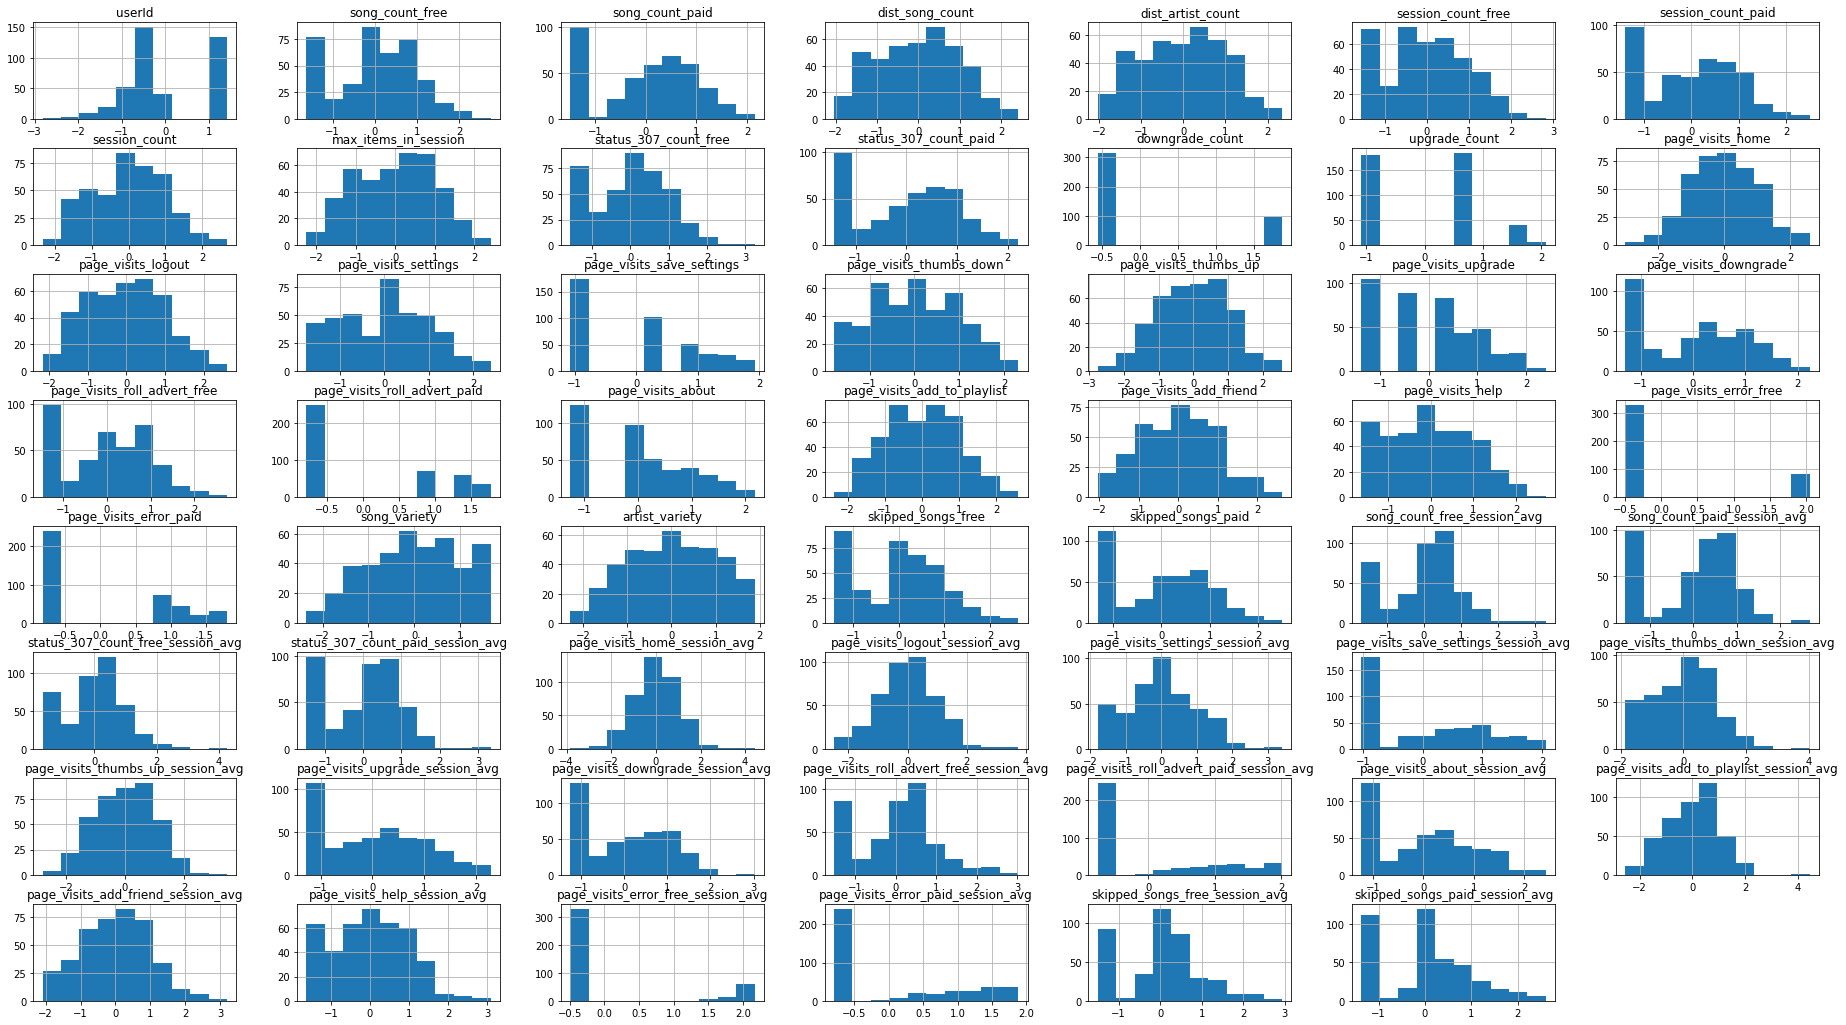

In [40]:
pt = PowerTransformer()
df_pt = df_div.drop(columns = ['churn'])
df_pt.iloc[:,:] = pt.fit_transform(df_pt.iloc[:,:])
df_pt.hist(figsize = (32,18));

#### Conclusion
##### Considering that test and validation sets contained around 40 entries, deriving a model, which have recall and F1 score over 0.6 can be considered a satisfactory result.
##### The final model has balanced performance:
##### * recall is over 60%, which allows to predict churn with sufficient confidence.
##### * the number of false positives is low, so that the model will not cause high unnecessary investment cost if churn prediction will be used to provide users with special offers.

## 2. Unsupervised learning.
Unsupervised learning methods do not require labels. Their goal is to discover intrinsic relationships in the data. Such methods can involve dimensionality reduction (Principal Components Analysis) or clustering (K-Means).

### 2.1. Dimensionality reduction with PCA

The first 5 components explain 87.50% of variance.


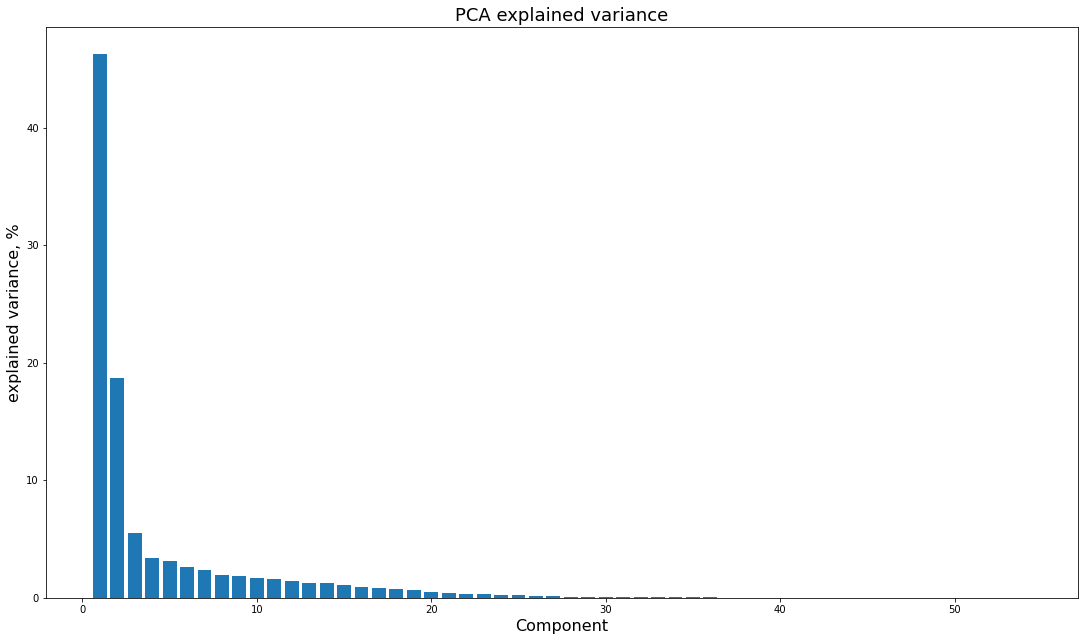

In [41]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42)
X = df_pt.drop(columns = ['userId'])
pca.fit(X)
plt.bar(range(1,55), 100*pca.explained_variance_ratio_)
plt.title('PCA explained variance', fontsize = 18)
plt.ylabel('explained variance, %', fontsize = 16)
plt.xlabel('Component', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
print('The first 5 components explain {:.2f}% of variance.'.format(100*pca.explained_variance_ratio_[:10].sum()))

In [42]:
pca = PCA(n_components = 10, random_state = 42)
X_pca = pca.fit_transform(X)

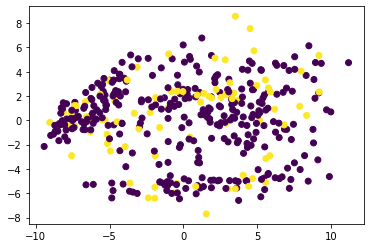

In [43]:
plt.scatter(x = X_pca[:,0], y = X_pca[:,1], c = df_div['churn']);

A plot of the distribution of the first two components. Churn is marked yellow.

### 2.2. Clustering with K-Means
We will apply K-Means to the transformed data to find the clusters of the users. In the next step we will see if churn can be localized to some of the clusters.

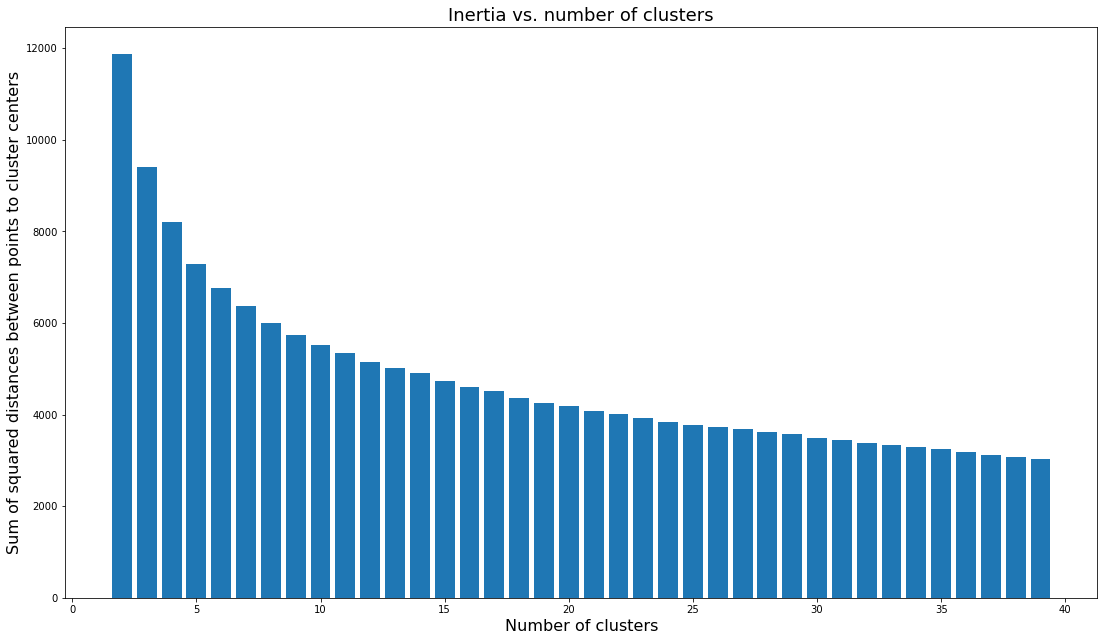

In [44]:
from sklearn.cluster import KMeans

inertia = []

for n_c in range(2,40):
    kmeans = KMeans(n_clusters = n_c, random_state = 42)
    kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)

plt.bar(range(2,40), inertia)
plt.title('Inertia vs. number of clusters', fontsize = 18)
plt.ylabel('Sum of squared distances between points to cluster centers', fontsize = 16)
plt.xlabel('Number of clusters', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

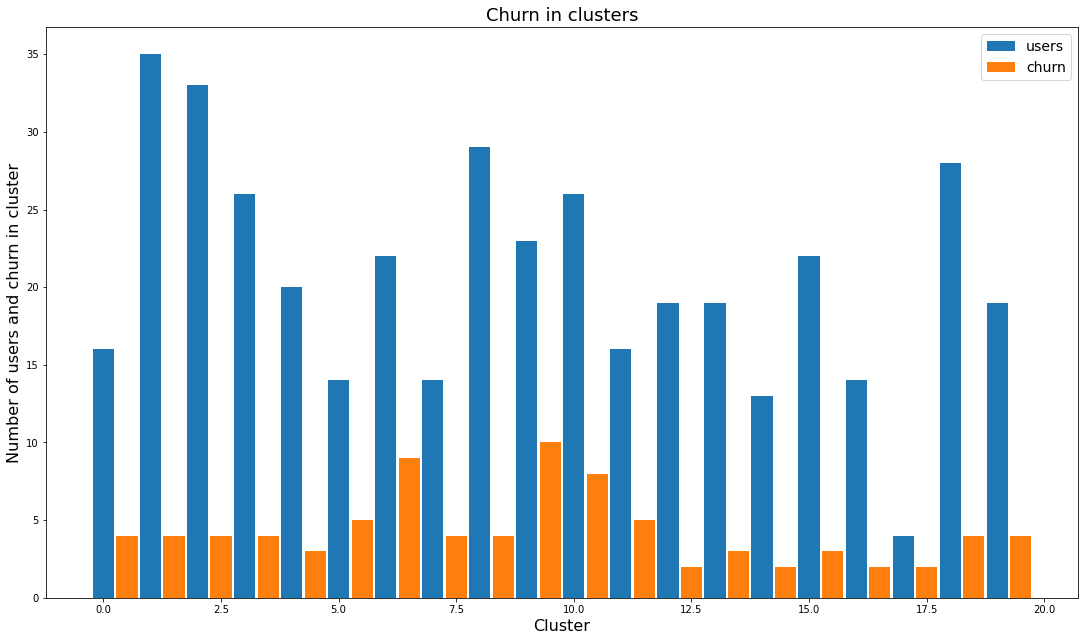

In [45]:
n_c = 20
kmeans = KMeans(n_clusters = n_c, random_state = 42)
labels = kmeans.fit_predict(X_pca).tolist()
df_kmeans = pd.DataFrame.from_dict({'userId':df_div['userId'].tolist(), 'churn':df_div['churn'].tolist(), 'cluster':labels})
plt.bar(np.arange(0,n_c), df_kmeans.groupby('cluster')['churn'].count(), width = 0.45, label = 'users')
plt.bar(np.arange(0,n_c) + 0.5, df_kmeans.groupby('cluster')['churn'].sum().tolist(), width = 0.45, label = 'churn')
plt.title('Churn in clusters', fontsize = 18)
plt.ylabel('Number of users and churn in cluster', fontsize = 16)
plt.xlabel('Cluster', fontsize = 16)
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### 2.3 Looking at PCA components

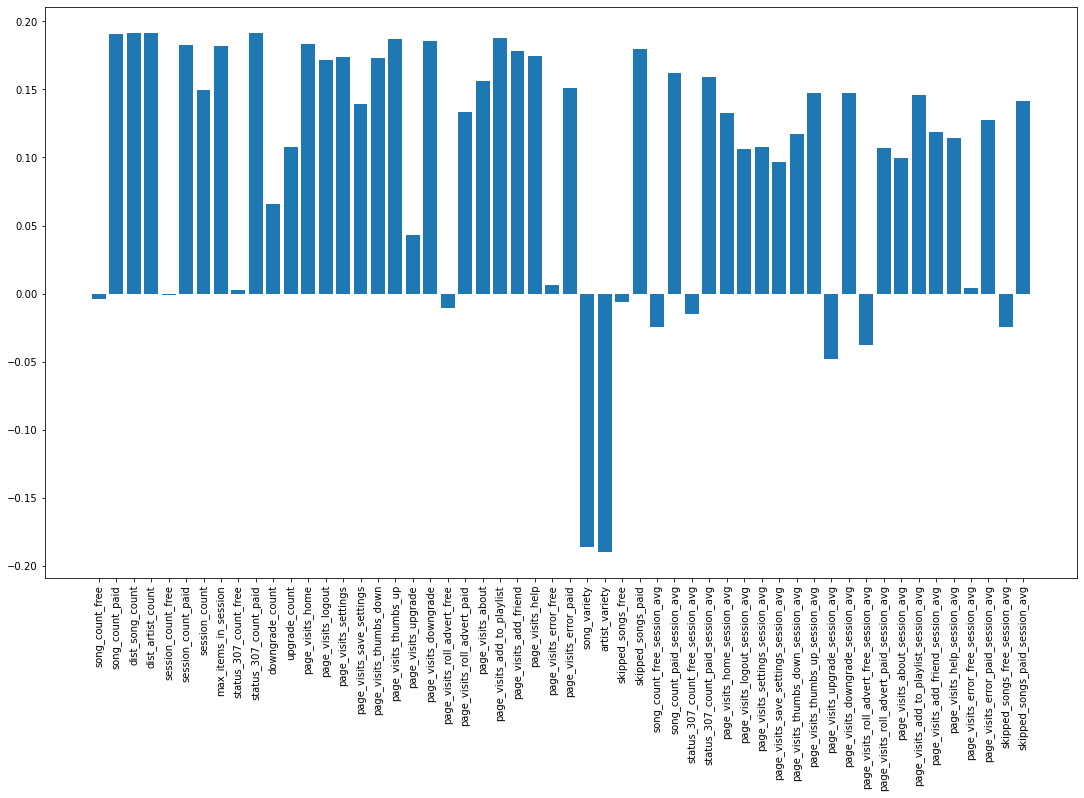

In [46]:
pca = PCA(n_components = 10, random_state = 42)
X_pca = pca.fit_transform(X)

plt.bar(np.arange(1,55),pca.components_[0])
plt.xticks(np.arange(1,55), X.columns, rotation = 90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

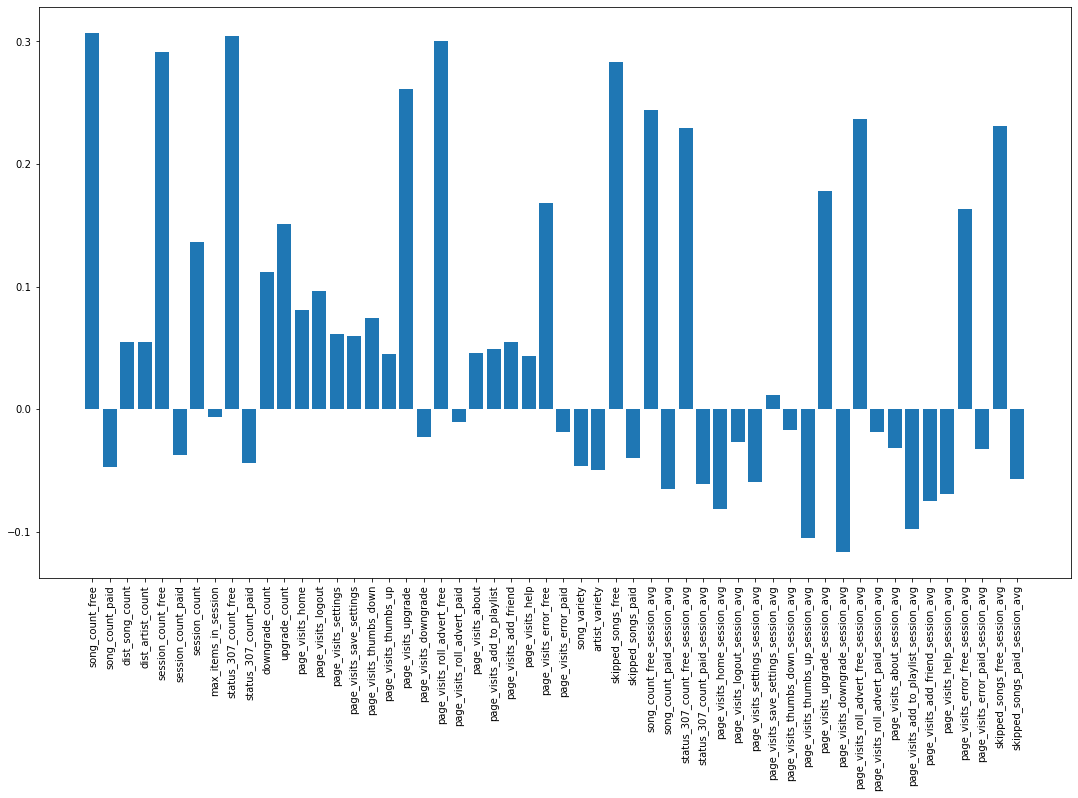

In [47]:
plt.bar(np.arange(1,55),pca.components_[1])
plt.xticks(np.arange(1,55), X.columns, rotation = 90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

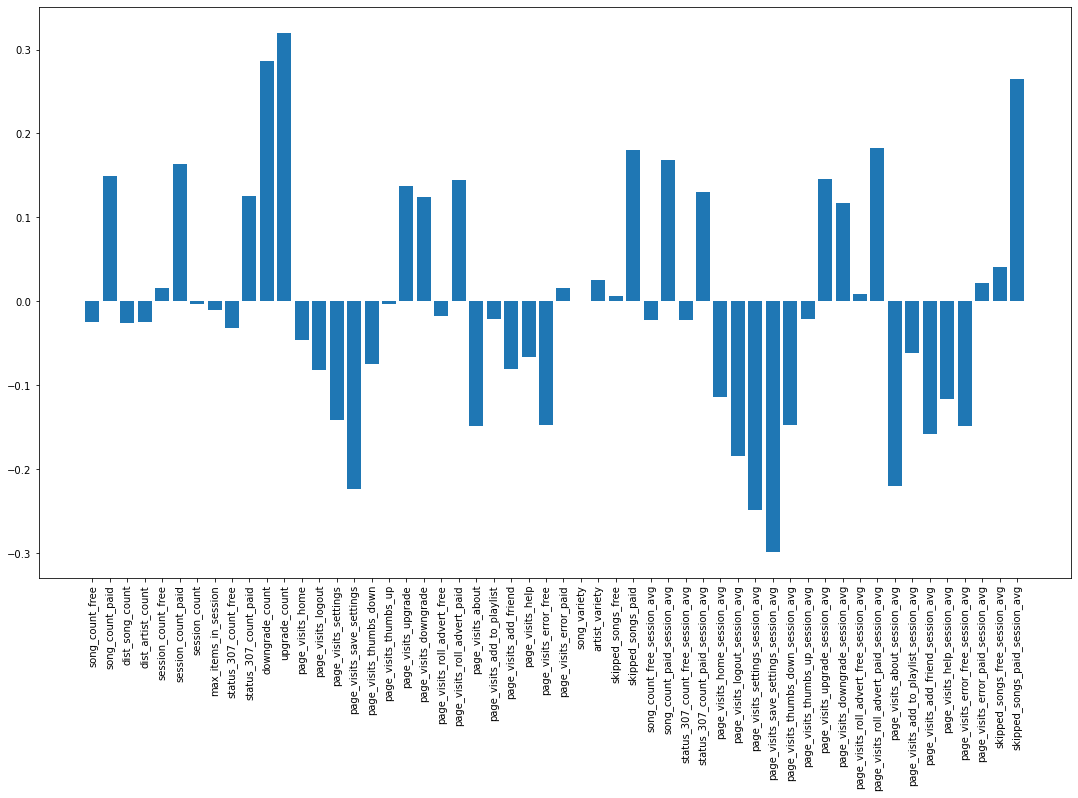

In [48]:
plt.bar(np.arange(1,55),pca.components_[3])
plt.xticks(np.arange(1,55), X.columns, rotation = 90)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### 2.4 Discussion
#### PCA
 * It is possible to reduce the dimensionality of the dataset from 55 to 10 features and keep about 90% of variability.
 * The first feature explains about 43% of variability in the dataset. This feature can be mostly described as the usage intensity.
 * The second feature explains about 18% of variability in the dataset. This feature mostly differentiates free and paid account usage.
 * The third feature is related to usage of the account settings page.
#### K-Means
 * Due to low number of data points it is hard to get adequate clustering.
 * After experimenting with the number of principal components it is possible to find clustering options, which carve clusters, in which churn is slightly higher than in the others.

## 3. Improvement
There are several ways to improve the performance of the churn classification:
 * run ML on the full available dataset using a cloud computing SPARK cluster
 * use machine learning for time series prediction algorithms instead of analysing statistics.
 * create new features, which show how user's interaction with the service changed over time and apply the existing ML pipeline.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [49]:
import os

os.system('jupyter nbconvert --to html Sparkify_Feature_Engineering.ipynb')

0